In [54]:
import nltk
import gensim
import pandas as pd
import re
import keras
import numpy as np

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [56]:
df = pd.read_csv('train.csv')

In [57]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [58]:
## number of sarcasm 
df_new = df.iloc[:,3:]

In [59]:
df_new.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot:>

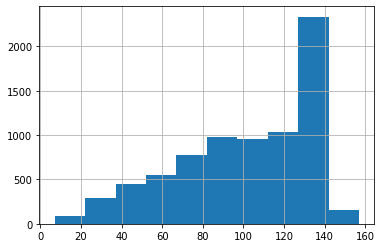

In [60]:
df_new['text'].str.len().hist() ## no. of characters

<function matplotlib.pyplot.show(close=None, block=None)>

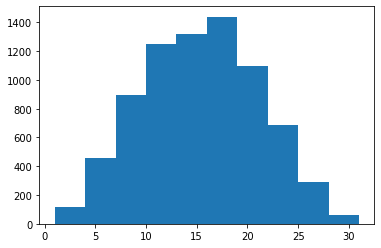

In [61]:
## no. of words 
count = []
for plot in df_new.text:
    words = plot.split()
    count.append(len(words))
    
plt.hist(count)
plt.show

<AxesSubplot:>

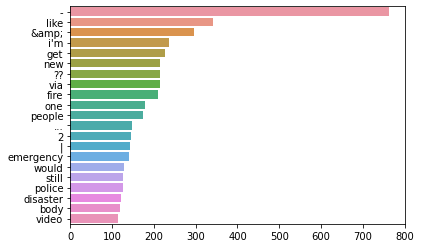

In [62]:
## creating a corpus of words for the analysis 
stop = set(nltk.corpus.stopwords.words('english'))
corpus=[]
p= df_new.text.str.split()
p=p.values.tolist()

corpus=[word.lower() for i in p for word in i if word not in stop]   ## lowering the word before adding to corpus

from collections import Counter
counter = Counter(corpus)
freq = counter.most_common()

x, y= [], []
for word,count in freq[:30]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

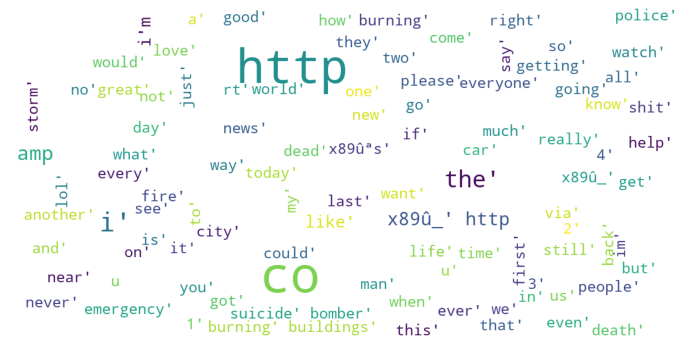

In [63]:
## USING WORDCLOUD
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(corpus)

In [64]:
X = df_new.text
Y= df_new.target

In [65]:
x_list = []   ## removing stopwords
for i in X:
       
    wor = i.split()
    filtered_words = [w for w in wor if w not in stop]
    i = filtered_words
    i= ' '.join(i)
    x_list.append(i)
    

In [66]:
x = np.array(x_list)
y = np.array(Y)

In [67]:
## tokenize the word to create embedding
vocab_size = 2000
tk = keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(x)
x_new = tk.texts_to_sequences(x)
word_index = tk.word_index  # index of unique words
print('Found %s unique tokens.' % len(word_index))

Found 22692 unique tokens.


In [68]:
## avg tokens per sentence
count = 0
for i in range(len(x_new)):
    count = count + len(x_new[i])
    
count/len(x_new)  ### 10 words per tweet avg

8.985682385393407

In [69]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
max_len = 50       #length of sequence
batch_size = 32
epochs = 5
max_features = 100
x_new = pad_sequences(x_new, maxlen=max_len, padding='pre')
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)

In [70]:
x_train.shape

(6090, 50)

## normal model

In [71]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Sequential
def RNN():
    model = Sequential()
    model.add(Embedding(vocab_size,max_features,input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(256,activation='relu',kernel_initializer="he_uniform"))
    
    model.add(Dense(1,activation='sigmoid',kernel_initializer="glorot_uniform"))
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_41 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 259,137
Trainable params: 259,137
Non-trainable params: 0
_________________________________________________________________


In [72]:
from keras.callbacks import EarlyStopping
model.fit(x_train, y_train,validation_data= (x_test, y_test), epochs= epochs, batch_size = batch_size,)


#callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]


Epoch 1/5
191/191 [==============================] - 10s 40ms/step - loss: 0.6089 - accuracy: 0.6666 - val_loss: 0.4422 - val_accuracy: 0.8024
Epoch 2/5
191/191 [==============================] - 7s 35ms/step - loss: 0.3678 - accuracy: 0.8470 - val_loss: 0.4498 - val_accuracy: 0.7991
Epoch 3/5
191/191 [==============================] - 7s 38ms/step - loss: 0.3129 - accuracy: 0.8728 - val_loss: 0.4914 - val_accuracy: 0.7748
Epoch 4/5
191/191 [==============================] - 6s 33ms/step - loss: 0.2647 - accuracy: 0.8963 - val_loss: 0.5386 - val_accuracy: 0.7761
Epoch 5/5
191/191 [==============================] - 7s 35ms/step - loss: 0.2130 - accuracy: 0.9155 - val_loss: 0.6754 - val_accuracy: 0.7498


In [73]:
model.evaluate(x_test,y_test)

48/48 [==============================] - 1s 12ms/step - loss: 0.6754 - accuracy: 0.7498


[0.6753894090652466, 0.7498358488082886]

## keras tuner

In [51]:
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout

## this is a build function we define
def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size,max_features,input_length=max_len))
    for i in range(hp.Int('layers1',1,10)):
        model.add(LSTM(units=hp.Int('unit_'+str(i),
                                     min_value=32,
                                     max_value=532,
                                     step=32),return_sequences=True))
    model.add(LSTM(units=hp.Int('unit_'+str(i),
                                     min_value=32,
                                     max_value=532,
                                     step=32)))
    for i in range(hp.Int('layers2',1,50)):
        model.add(Dense(units=hp.Int('unit_'+str(i),
                                     min_value=32,
                                     max_value=532,
                                     step=32),activation='relu',kernel_initializer="he_uniform"))   

    model.add(Dense(units=1,activation='sigmoid',kernel_initializer="glorot_uniform"))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-2,1e-3,1e-4])),
                 loss=keras.losses.binary_crossentropy,
                 metrics=['accuracy'])
    return model
                  
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial = 2,
    directory='.',
    project_name='my_project'
    

)

NameError: name 'RandomSearch' is not defined

In [ ]:
## tuner tuned in collab
tuner.search(x_train,y_train,
            validation_data=(x_test,y_test),
             epochs=5)

## from kerastuner
Results summary
Results in ./my_project_4
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers1: 3
unit_0: 256
layers2: 21
learning_rate: 0.0001
unit_1: 32
unit_2: 32
unit_3: 32
unit_4: 32
unit_5: 32
unit_6: 32
unit_7: 32
unit_8: 32
unit_9: 32
unit_10: 32
unit_11: 32
unit_12: 32
unit_13: 32
unit_14: 32
unit_15: 32
unit_16: 32
unit_17: 32
unit_18: 32
unit_19: 32
unit_20: 32
Score: 0.8095863461494446
Trial summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding (Embedding)        (None, 50, 100)           200000    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 256)           365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 32)            36992     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
=================================================================
Total params: 655,969
Trainable params: 655,969
Non-trainable params: 0

In [27]:
def make_model(l1,n1,l2,n2=32):
    model = Sequential()
    model.add(Embedding(vocab_size,max_features,input_length=max_len))
    for i in range(l1):
        model.add(LSTM(n1[i],return_sequences=True))
        
    model.add(LSTM(32))   
    
    for i in range(l2):
        model.add(Dense(n2,activation='relu',kernel_initializer="he_uniform"))
    
    model.add(Dense(units=1,activation='sigmoid',kernel_initializer="glorot_uniform"))
    model.compile(optimizer=keras.optimizers.Adam(0.0001),
                 loss=keras.losses.binary_crossentropy,
                 metrics=['accuracy'])

    return model

In [30]:
l1 = 3
n1 = [256,32,32]
l2 = 20

model_tuned = make_model(l1,n1,l2)


In [31]:
model_tuned.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 256)           365568    
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 32)            36992     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 32)               

In [32]:
model_tuned.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,batch_size=32)

Epoch 1/5
191/191 [==============================] - 63s 288ms/step - loss: 0.6840 - accuracy: 0.5775 - val_loss: 0.6756 - val_accuracy: 0.6382
Epoch 2/5
191/191 [==============================] - 48s 250ms/step - loss: 0.6490 - accuracy: 0.6321 - val_loss: 0.5483 - val_accuracy: 0.7905
Epoch 3/5
191/191 [==============================] - 48s 254ms/step - loss: 0.5042 - accuracy: 0.7945 - val_loss: 0.4482 - val_accuracy: 0.8070
Epoch 4/5
191/191 [==============================] - 44s 229ms/step - loss: 0.3956 - accuracy: 0.8364 - val_loss: 0.4591 - val_accuracy: 0.7997
Epoch 5/5
191/191 [==============================] - 42s 220ms/step - loss: 0.3616 - accuracy: 0.8586 - val_loss: 0.4517 - val_accuracy: 0.8096


In [74]:
## new way, json and h5py
# serialize model to JSON
model_json = model_tuned.to_json()
with open("model_disaster_pre.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_disaster.h5")
print("Saved model to disk")

## did not work

## new way, json and h5py
# serialize model to JSON
model_json = model_tuned.to_json()
with open("model_disaster_tuned.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_tuned.save_weights("model_disaster_tuned.h5")
print("Saved model to disk")

## did not work

Saved model to disk
Saved model to disk


## ON DATA WITH NO LABEL GIVEN

In [37]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [38]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_disaster_pre.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_disaster.h5")
print("Loaded model from disk")

loaded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Loaded model from disk


In [39]:
stop = set(nltk.corpus.stopwords.words('english'))
X = test_data.text
x_list = []   ## removing stopwords
for i in X:
       
    wor = i.split()
    filtered_words = [w for w in wor if w not in stop]
    i = filtered_words
    i= ' '.join(i)
    x_list.append(i)
    
x = np.array(x_list)

    
## tokenize the word to create embedding
vocab_size = 2000
tk = keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(x)
x_new = tk.texts_to_sequences(x)
word_index = tk.word_index  # index of unique words
print('Found %s unique tokens.' % len(word_index))

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
max_len = 50       #length of sequence
batch_size = 32
epochs = 5
max_features = 100
x_test = pad_sequences(x_new, maxlen=max_len, padding='pre')

Found 12800 unique tokens.


In [40]:
x_test.shape

(3263, 50)

In [42]:
y_pred = loaded_model.predict(x_test)
y_pred_new = model_tuned.predict(x_test)

In [50]:
for i in range(100):
    input1 = test_data.text[i]
    print(input1)
    
    op = model_tuned.predict(x_test[i].reshape(1,50))
    if op>0.5:
        op=1
    else: 
        op = 0

    print("prediction: ",op)
    print('------')


Just happened a terrible car crash
prediction:  0
------
Heard about #earthquake is different cities, stay safe everyone.
prediction:  0
------
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
prediction:  1
------
Apocalypse lighting. #Spokane #wildfires
prediction:  0
------
Typhoon Soudelor kills 28 in China and Taiwan
prediction:  1
------
We're shaking...It's an earthquake
prediction:  0
------
They'd probably still show more life than Arsenal did yesterday, eh? EH?
prediction:  1
------
Hey! How are you?
prediction:  0
------
What a nice hat?
prediction:  0
------
Fuck off!
prediction:  0
------
No I don't like cold!
prediction:  0
------
NOOOOOOOOO! Don't do that!
prediction:  0
------
No don't tell me that!
prediction:  0
------
What if?!
prediction:  0
------
Awesome!
prediction:  0
------
Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market http://t.co/irWqCEZWEU
prediction:  1
------

prediction:  1
------
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wedn...  http://t.co/KuBsM16OuD
prediction:  1
------
Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/zdsug0UjS7
prediction:  0
------
http://t.co/Q5XTkaKM08 I'M DYING SEND AN AMBULANCE @M__Belly @brightasastar_
prediction:  0
------
AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/7X3PDDbT0Z
prediction:  1
------
@disneyxrowbrina the ambulance isn't even parked well like its nearly on top of someone's car I'm laughing
prediction:  0
------
Shot 12 times. Found dead in cuffs after being involved in a car accident. Officers told ambulance not to treat him. https://t.co/MEUDJwaaNg
prediction:  1
------
@margaretcho Call me a fag and I'm going to call you an ambulance :) #RainbowPower
prediction:  0
------
New Nanotech Device Will Be Able To Target And Destroy Blood Clots http://t.co/MnmyJXQ